In [42]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from abc import ABCMeta
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

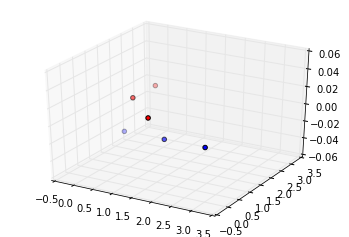

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Creating a simple data set
n = 6
d = 2 
X = np.zeros((n,d))
y = np.zeros(n)
A = np.zeros((n,d))

X[0,:] = [1,1]
X[1,:] = [0,2]
X[2,:] = [0,3]
X[3,:] = [1,0]
X[4,:] = [2,0]
X[5,:] = [3,0]
y = np.zeros(n)
y[0:3] = 1
y[3:6] = -1
plt.scatter(X[0:3,0],X[0:3,1], c = "r")
plt.scatter(X[3:6,0],X[3:6,1], c = "b")
for i in range(n): 
    A[i,:] = y[i]*X[i,:]

In [44]:
X.shape

(200, 3)

In [64]:
import operator
    
def sortbyindeces(a):
  return [i[0] for i in sorted(enumerate(a), key=lambda a:a[1],reverse=True)]

class SVM_DCA(object):
    def __init__(self, X,lambd,verbose = False):
        self.X = X
        self.verbose = verbose
        self.lambd = lambd
        self.n, self.d = X.shape
    def w_alpha(self,alpha): # check the equation 3 of (SDCA) paper
        X = self.X
        lambd = self.lambd
        n, d = X.shape
        pw = np.zeros(d)
        for i in range(n): 
            pw = pw + alpha[i]*X[i,:]/lambd
        pw = pw/n
        return pw 
    def dual_func(self,alpha): # computes the dual function value for a given parameter alpha 
        da = 0
        n, d = self.X.shape
        for i in range(n): 
            if alpha[i] <= 1 and alpha[i] >= 0:
                da = da + alpha[i]
            else:
                da = da + float("inf")
        da = da / n 
        da = da - 0.5*self.lambd*np.square(np.linalg.norm(self.w_alpha(alpha)))
        return da
    def primal_func(self,w): # computes the primal value for the given parameter w
        n, d = self.X.shape
        pw = 0
        for i in range(n): 
           pw = pw + max(0,1-np.dot(w,self.X[i,:]))
        pw = pw/n 
        pw = pw + 0.5*self.lambd*np.square(np.linalg.norm(w))
        return pw
    def get_name(self): 
        return ("Stochastic coordinate Ascent for SVM")
    def get_coordinate(self,alpha,w):
        return ( np.random.randint(0, self.n))
    def opt(self,num_steps,T0):
      X = self.X
      lambd = self.lambd
      verbose= self.verbose
      if verbose:
        print(self.get_name())
      inv_sq_row_norms = np.divide(1.0, np.square(np.linalg.norm(X, axis=1)))
      n, d = X.shape
      # it might be better to change initial value of alpha 
      alpha = np.zeros(n)
      #setting w(alpha_0)
      w = self.w_alpha(alpha)
      duals = np.zeros(num_steps)# dual function values per iteration
      primals = np.zeros(num_steps) #primal function values per iteration 
      if verbose:
        primal_value = self.primal_func(w)
        dual_value = self.dual_func(alpha)
        print("Initial primal objective value: {}, Intial dual objective value: {}".format(primal_value, dual_value))
      w_bar = np.zeros(d)
      T_T0 = 0
      alpha_bar = np.zeros(n)
      for cur_step in range(num_steps):
        ii = self.get_coordinate(alpha,w)
        alpha_i_old = alpha[ii]
        xi = X[ii,:]
        inv_sqi = inv_sq_row_norms[ii]
        # coordinate update step 
        delta_alpha_i = max(0,min(1,(lambd*n*(1-np.dot(xi,w))*inv_sqi)+alpha_i_old)) - alpha_i_old
        # update the dual and primal paramters
        alpha[ii] = alpha[ii] + delta_alpha_i
        w = w + delta_alpha_i*xi/(lambd*n)
        if cur_step > T0:
           w_bar = w_bar + w
           alpha_bar = alpha_bar + alpha
           T_T0 = T_T0 +1 
        duals[cur_step] = self.dual_func(alpha)
        primals[cur_step] = self.primal_func(w)
        if verbose: #and cur_step % n == 0 and cur_step > 0
          print("step:{},primal: {},dual: {},ii = {}\n".format(cur_step,primals[cur_step], duals[cur_step], ii))
      return (w_bar/T_T0, alpha_bar/T_T0 ,primals,duals)
class SVM_Steepest(SVM_DCA):
     def get_name(self): 
        return ("Steepest coordinate Ascent for SVM")
     def get_coordinate(self,alpha,w):
        prods = np.dot(self.X,w)
        g_alpha = 1 - prods
        inds = sortbyindeces(abs(g_alpha))
        ii = inds[0]
        for i in range(self.n): 
            j = inds[i]
            if (alpha[j]> 0 and alpha[j]<1) or ((alpha[j] == 0) and (g_alpha[j] >= 0)) or ((alpha[j] == 1) and (g_alpha[j] <= 0)):
                ii = j
                break
            else: 
                print("Something bad :( {}")
        return (ii)
    
class LSH_Angle:
    def __init__(self,points,rep):
        n, d = points.shape
        HV = np.zeros((n,rep))
        SK = np.zeros((d,rep))
        for i in range(rep):
            SK[:,i] = np.random.normal(0,1,d)
            HV[:,i] = np.sign(np.dot(points,SK[:,i]))
        self.HV = HV
        self.SK = SK 
        self.rep = rep
    def query(self,q): 
        ii = np.random.randint(0, self.rep)
        bockets = self.HV[:,ii]
        sk = self.SK[:,ii]
        sq = np.sign(np.dot(q,sk))
        opposit_hashed = [j for j, e in enumerate(bockets) if e != sq]
        return (opposit_hashed)
    
class LSH_PI:
    def __init__(self,points,rep):
        n, d = points.shape
        HV1 = np.zeros((n,rep))
        HV2 = np.zeros((n,rep))
        SK1 = np.zeros((d,rep))
        SK2 = np.zeros((d,rep))
        for i in range(rep):
            SK1[:,i] = np.random.normal(0,1,d)
            SK2[:,i] = np.random.normal(0,1,d)
            HV1[:,i] = np.sign(np.dot(points,SK1[:,i]))
            HV2[:,i] = np.sign(np.dot(points,SK2[:,i]))
        self.HV1 = HV1
        self.HV2 = HV2
        self.SK1 = SK1
        self.SK2 = SK2
        self.rep = rep
    def query(self,q): 
        n, rep = self.HV1.shape
        ii = np.random.randint(0, self.rep)
        bockets1 = self.HV1[:,ii]
        sk1 = self.SK1[:,ii]
        bockets2 = self.HV2[:,ii]
        sk2 = self.SK2[:,ii]
        sq1 = np.sign(np.dot(q,sk1))
        sq2 = np.sign(np.dot(q,sk2))
        inds = np.zeros(n)
        for i in range(n): 
            if (bockets1[i] == sq1 ) and (bockets2[i] != sq2):
                inds[i] = 1
        opposit_hashed = [j for j, e in enumerate(inds) if e > 0]
        return (opposit_hashed)

class LSH_Angle_Level:
    def __init__(self,points,levels,rep):
        n, d = points.shape
        HV = np.zeros((n,levels,rep))
        SK = np.zeros((d,levels,rep))
        for i in range(rep):
            ProMat = np.random.normal(0,1,(d,levels))
            signs = np.sign(np.dot(points,ProMat));
            for j in range(n): 
                signs[j,:] = signs[j,:]
            HV[:,:,i] = signs
            SK[:,:,i] = ProMat
        self.HV = HV
        self.SK = SK 
        self.rep = rep
        self.levels = levels
    def query(self,q): 
        ii = np.random.randint(0, self.rep)
        cur_step = self.levels
        n,l,r = self.HV.shape
        while cur_step > 0: 
            bockets = self.HV[:,0:cur_step,ii]
            sk = self.SK[:,0:cur_step,ii] 
            sq = np.sign(np.dot(q,sk))  
            opposit_hashed = [j for j, e in enumerate(bockets) if (e != sq).all()]
            if(len(opposit_hashed) != 0):
              break
            else: 
              cur_step = cur_step -1 
        return (opposit_hashed)   
class SVM_LSHANG(SVM_DCA):
     def __init__(self, X,lambd,lsh,verbose = False):
        super(SVM_LSHANG, self).__init__(X,lambd,verbose = False)
        # LSH construction
        self.catches = 0
        self.lsh = lsh    
     def get_coordinate(self,alpha,w):
        opposit_hashed = self.lsh.query(w)
        if len(opposit_hashed)!=0: 
         ii = opposit_hashed[np.random.randint(0, len(opposit_hashed))]
        else: 
         ii = np.random.randint(0,self.n)
        g_alpha_y = (1 - np.dot(self.X[ii,],w))
        if ((alpha[ii] == 0) and (g_alpha_y <= 0)) or ((alpha[ii] == 1) and (g_alpha_y >= 0)):
          if self.verbose: 
            print("Blocked: alpha = {}, target value = {}".format(alpha[ii],g_alpha_y))
        else: 
          self.catches = self.catches +1
          if self.verbose:
            print("Catched:alpha ={},target value = {}".format(alpha[ii],g_alpha_y))
        return(ii)

In [65]:
lambd = 0.001
itr = 500
svm_r = SVM_DCA(A,lambd,verbose= False)
#svm_s = SVM_Steepest(X,lambd,verbose=True)
#ls = LSH_Angle_Level(X,3,20)
#svm_l = SVM_LSHANG(X,lambd,ls)
w, alpha, primals, duals = svm_r.opt(itr,itr -2)
#w_s, alpha_s, primals_s, duals_s = svm_s.opt(itr,itr -2)
#w_l, alpha_l, primals_l, duals_l = svm_l.opt(itr,itr -2)

In [68]:
from sklearn import svm
clf = svm.LinearSVC(C = float("inf"),fit_intercept=False)
clf.fit(X, y) 
clf.coef_

array([[-0.9999644,  1.9999644]])

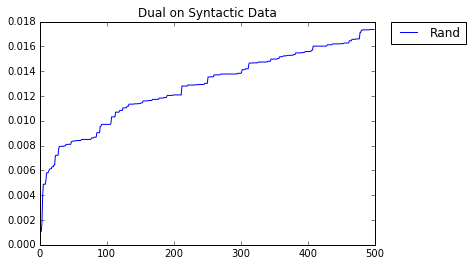

In [33]:
plt.plot(duals,label = 'Rand')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Dual on Syntactic Data")

In [70]:
clf.coef_

array([[-0.9999644,  1.9999644]])

In [69]:
w

array([-1.,  2.])